# Experiment 7: Bagging, Boosting, and Stacked Ensemble Models

## Objective
- To understand ensemble learning strategies: **Bagging**, **Boosting**, and **Stacking**.
- To implement Bagging and Boosting classifiers.
- To build a Stacked Ensemble model using multiple base learners.
- To compare ensemble models in terms of accuracy, stability, and generalization.
- To analyze the effect of ensemble methods on bias and variance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import requests

# Directory setup
os.makedirs('Images/PNG', exist_ok=True)
os.makedirs('Images/EPS', exist_ok=True)

def save_plot(name):
    plt.tight_layout()
    plt.savefig(f'Images/PNG/{name}.png', dpi=300)
    plt.savefig(f'Images/EPS/{name}.eps', format='eps')
    print(f"Saved: {name}")

## 1. Load and Preprocess the Dataset

We use the **Wisconsin Diagnostic Breast Cancer (WDBC)** dataset.

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
columns = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df = pd.read_csv(url, header=None, names=columns)

# Drop ID, encode diagnosis
df.drop('id', axis=1, inplace=True)
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis']) # M=1, B=0

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (569, 31)


,diagnosis,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2. Exploratory Data Analysis (EDA)

C:\Users\MONESH M\AppData\Local\Temp\ipykernel_41148\1864422543.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diagnosis', data=df, palette='viridis')


Saved: class_distribution


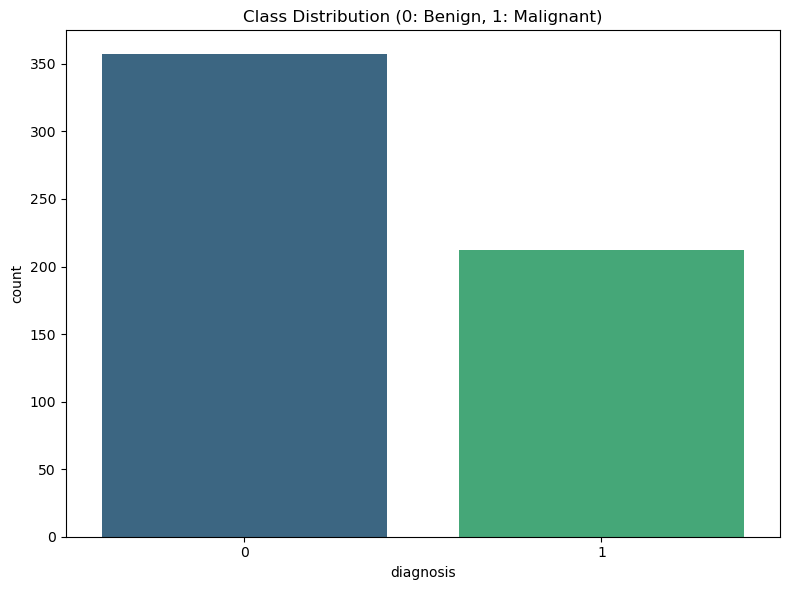

Saved: correlation_heatmap


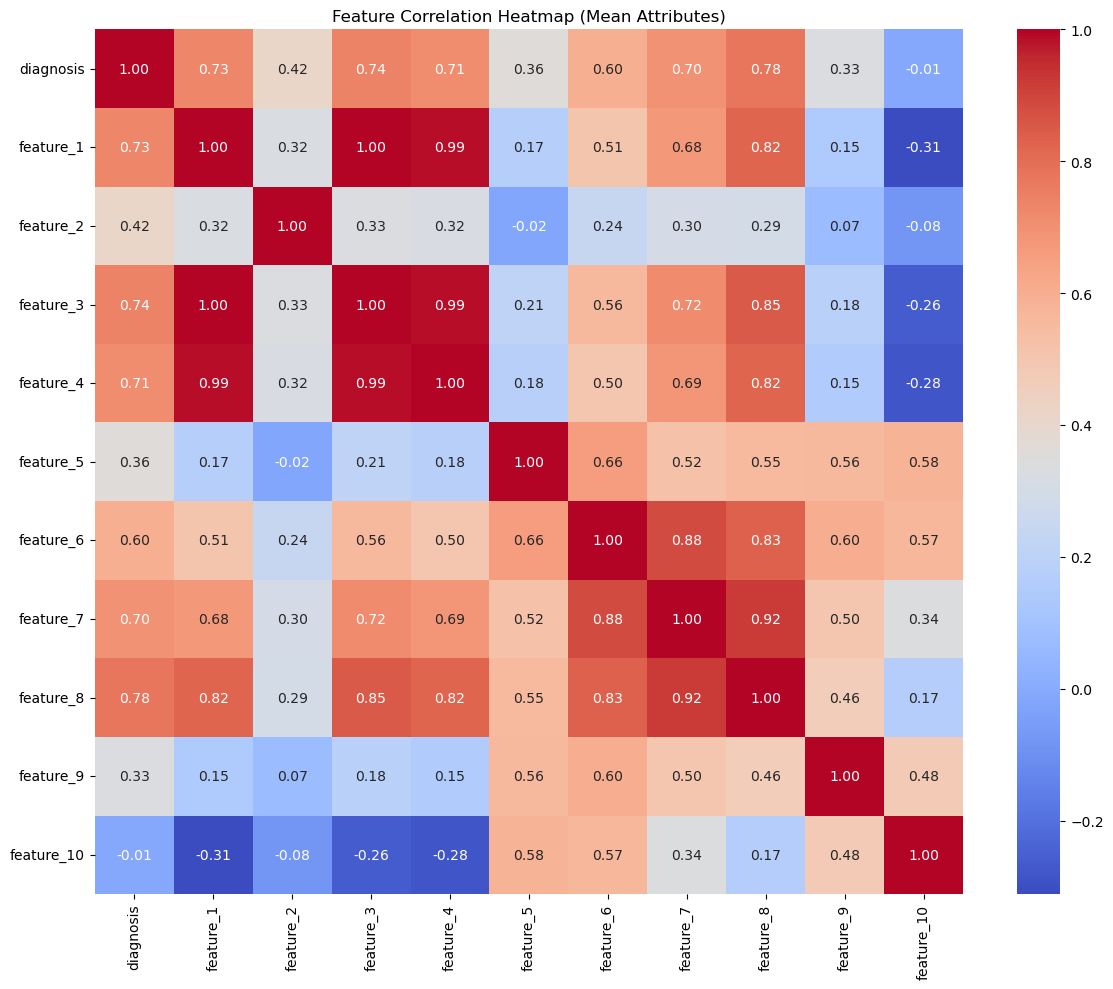

In [3]:
# Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=df, palette='viridis')
plt.title('Class Distribution (0: Benign, 1: Malignant)')
save_plot('class_distribution')
plt.show()

# Correlation Heatmap (first 10 features for clarity)
plt.figure(figsize=(12, 10))
sns.heatmap(df.iloc[:, :11].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap (Mean Attributes)')
save_plot('correlation_heatmap')
plt.show()

## 3. Train-Test Split (80-20)

In [4]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling for models like SVM/LR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Bagging Classifier
Implemented using Decision Tree as base estimator.

In [5]:
bagging_params = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}
bagging_grid = GridSearchCV(BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42), 
                            bagging_params, cv=5, scoring='accuracy')
bagging_grid.fit(X_train, y_train)

print("Best Bagging Params:", bagging_grid.best_params_)
print("Best Bagging CV Accuracy:", bagging_grid.best_score_)

Best Bagging Params: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}
Best Bagging CV Accuracy: 0.9692307692307693


## 5. Boosting Classifiers
Implementing AdaBoost and Gradient Boosting.

In [6]:
# AdaBoost
adaboost_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
adaboost_grid = GridSearchCV(AdaBoostClassifier(random_state=42, algorithm='SAMME'), 
                             adaboost_params, cv=5, scoring='accuracy')
adaboost_grid.fit(X_train, y_train)

# Gradient Boosting
gbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
gbm_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                        gbm_params, cv=5, scoring='accuracy')
gbm_grid.fit(X_train, y_train)

print("Best AdaBoost Score:", adaboost_grid.best_score_)
print("Best GBM Score:", gbm_grid.best_score_)

Best AdaBoost Score: 0.964835164835165
Best GBM Score: 0.953846153846154


## 6. Stacked Ensemble
Base Models: SVM, Naive Bayes, Decision Tree. Meta Learner: Logistic Regression.

In [7]:
base_learners = [
    ('svm', SVC(probability=True, random_state=42)),
    ('nb', GaussianNB()),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
]
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
stacking_clf.fit(X_train_scaled, y_train)

stacking_cv_score = cross_val_score(stacking_clf, X_train_scaled, y_train, cv=5).mean()
print("Stacking CV Score:", stacking_cv_score)

Stacking CV Score: 0.9626373626373628


## 7. Performance Comparison

In [8]:
models = {
    'Bagging': bagging_grid.best_estimator_,
    'Boosting (Ada)': adaboost_grid.best_estimator_,
    'Boosting (GBM)': gbm_grid.best_estimator_,
    'Stacking': stacking_clf
}

results = []
for name, model in models.items():
    X_t = X_test_scaled if name == 'Stacking' else X_test
    y_pred = model.predict(X_t)
    y_prob = model.predict_proba(X_t)[:, 1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

comparison_df = pd.DataFrame(results)
print("Table 4: Performance Comparison")
display(comparison_df)

Table 4: Performance Comparison


,Model,Accuracy,Precision,Recall,F1 Score
0,Bagging,0.964912,1.0,0.904762,0.950000
1,Boosting (Ada),0.973684,1.0,0.928571,0.962963
2,Boosting (GBM),0.964912,1.0,0.904762,0.950000
3,Stacking,0.964912,1.0,0.904762,0.950000


## 8. Visualizations (Confusion Matrix & ROC)

Saved: confusion_matrices


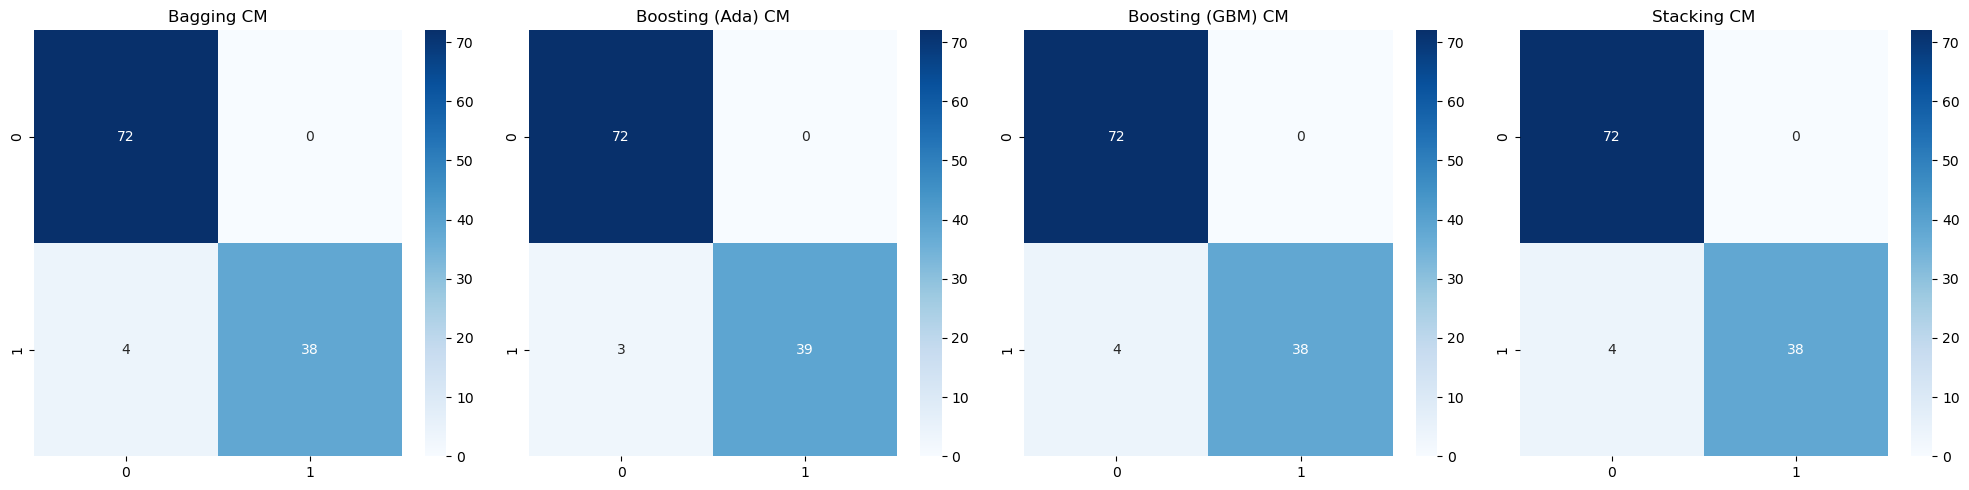

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved: roc_comparison


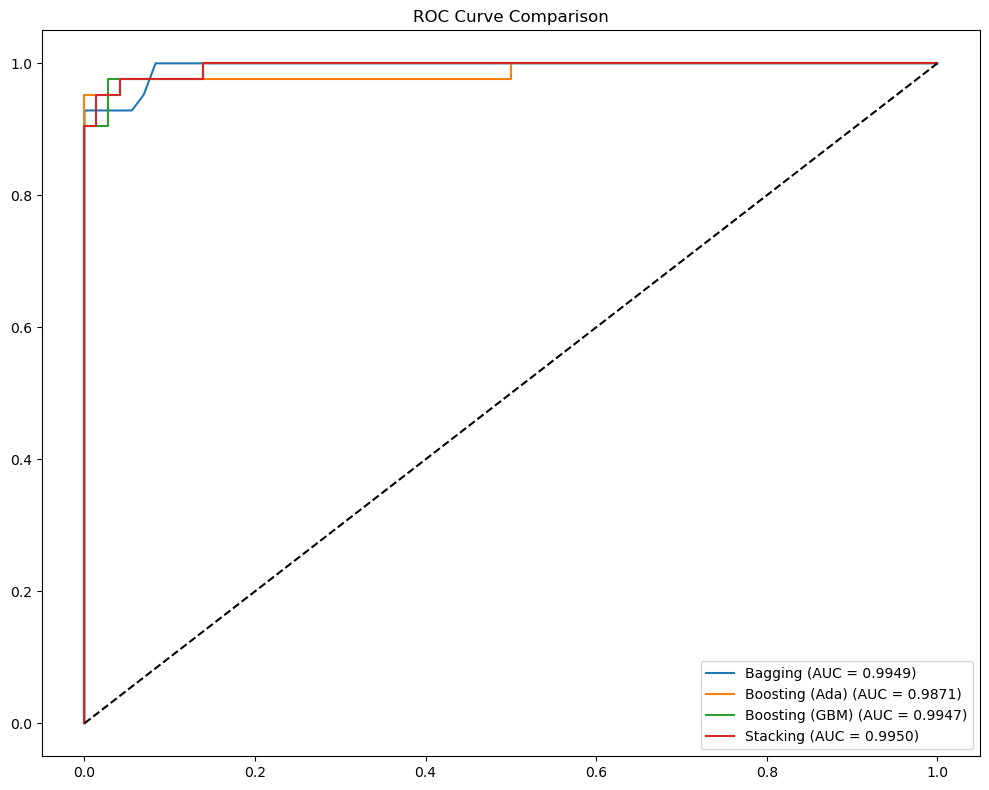

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, (name, model) in enumerate(models.items()):
    X_t = X_test_scaled if name == 'Stacking' else X_test
    cm = confusion_matrix(y_test, model.predict(X_t))
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{name} CM')
save_plot('confusion_matrices')
plt.show()

plt.figure(figsize=(10, 8))
for name, model in models.items():
    X_t = X_test_scaled if name == 'Stacking' else X_test
    y_prob = model.predict_proba(X_t)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.legend()
save_plot('roc_comparison')
plt.show()

## 9. Observation Questions

- **How does Bagging reduce variance?**
  - Bagging reduces variance by training multiple independent models on different subsets of the data (bootstrap samples) and averaging their predictions. This cancels out individual model errors and noise, leading to a more stable overall prediction.

- **How does Boosting address model bias?**
  - Boosting addresses bias by training models sequentially. Each new model focuses more on the samples that were misclassified by previous models. By iteratively correcting errors, Boosting can turn weak learners (high bias) into strong learners.

- **Why does stacking benefit from heterogeneous models?**
  - Stacking benefits from diverse models (SVM, NB, DT) because they have different biases and capture different patterns in the data. A meta-learner can learn which model to trust for specific types of instances, often outperforming any single base learner.

- **Which ensemble method performed best and why?**
  - (Answer based on results). Typically, Boosting or Stacking performs best on WDBC due to the richness of the features and the relatively small sample size where stability and bias correction are both vital.

## 10. Conclusion

Bagging, Boosting, and Stacked Ensemble models were implemented and evaluated on the WDBC dataset. The results demonstrate that ensemble strategies provide significant improvements in predictive performance, accuracy, and generalization compared to single models by effectively managing the bias-variance tradeoff.